

# What have I done?

* **Explored the smaller datasets:**
    * **stores.csv**
    * **items.csv**
    * **transactions.csv**
    * **holidays_events.csv**
    * **oil.csv**
    
* **Performed each of the following on the above csv files:**
    * **Checking for missing vlaues**
    * **Analyzing Datatypes**
    * **Data Explorations and Visualisation**
    * **One-Hot Encoding (of string type columns)**
    * **Memory reduction (so as to keep minimal memory while merging all dataframes)([SEE THIS KERNEL FOR MORE](https://www.kaggle.com/jeru666/zillow-revamped-with-memory-reduction))**

# What is to be done?

* **Analysis of train dataset**
* **Merge the above dataframes with train dataset and perform further analysis**
* **Release a baseline model**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns
import missingno as msno

from subprocess import check_output

df_train = pd.read_csv("../input/train.csv", nrows=6000000)
#df_test = pd.read_csv('../input/test.csv')
#df_sample = pd.read_csv('../input/sample_submission.csv')
df_stores = pd.read_csv('../input/stores.csv')
df_items = pd.read_csv('../input/items.csv')
df_transactions = pd.read_csv('../input/transactions.csv')
df_oil = pd.read_csv('../input/oil.csv')
df_holidays_events = pd.read_csv('../input/holidays_events.csv')

## Memory Reduction
The following is code snippet used to reduce memory wherever possible. I will be calling these functions after analyzing each and every csv file. I have done this to keep a minimal memory constraint when we finally merge all the dataframes to feed it for machine learning algorithms.

In [2]:
#--- for integer type columns ---
def change_datatype(df):
    float_cols = list(df.select_dtypes(include=['int']).columns)
    for col in float_cols:
        if ((np.max(df[col]) <= 127) and(np.min(df[col] >= -128))):
            df[col] = df[col].astype(np.int8)
        elif ((np.max(df[col]) <= 32767) and(np.min(df[col] >= -32768))):
            df[col] = df[col].astype(np.int16)
        elif ((np.max(df[col]) <= 2147483647) and(np.min(df[col] >= -2147483648))):
            df[col] = df[col].astype(np.int32)
        else:
            df[col] = df[col].astype(np.int64)

#--- for float type columns ---
def change_datatype_float(df):
    float_cols = list(df.select_dtypes(include=['float']).columns)
    for col in float_cols:
        df[col] = df[col].astype(np.float32)            

# 1. stores.csv

 First let us explore the csv files apart from the train data. Since we have to merge the others to the train data, we can analyze the others first.

In [3]:
print(df_stores.shape)
df_stores.head()

(54, 5)


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


### Intuition:
**stores.csv** file provides data for each unique store in the country:
* Each store is represented by a unique ID **store_nbr**.
* The **city** and **state** of its location is also provided. 
* Each store is of particular **type** (grocery, stationary, furniture, automotive, etc.)
* Every store has a **cluster** of similar stores. These are probably branches of the same store spread across the country.

## Checking Missing Values

In [4]:
df_stores.isnull().values.any()

False

## Analyzing Datatypes

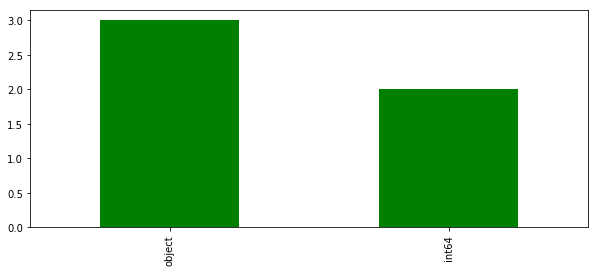

[dtype('int64') dtype('O')]
2


In [50]:
pp = pd.value_counts(df_stores.dtypes)
fig = plt.figure(figsize=(10,4))
pp.plot.bar(color='green')
plt.show()

print(df_stores.dtypes.unique())
print(df_stores.dtypes.nunique())

## Data Exploration & Visualisation
** Number of unique stores **

In [9]:
df_stores.store_nbr.nunique()

54

**Stores distribution across cities**

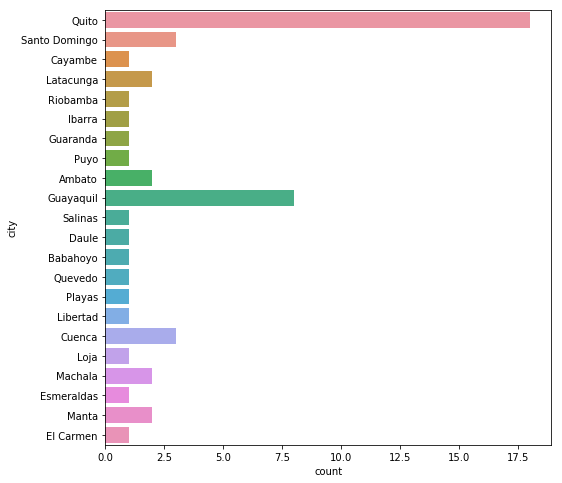

In [10]:
#--- Various cities distribution ---
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
ax = sns.countplot(y=df_stores['city'], data=df_stores) 

Most of the stores are located in Quito and Guayaquil.

**Stores distribution across states**

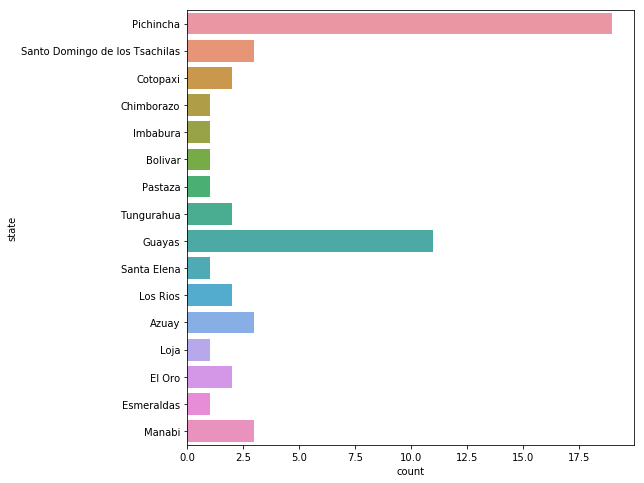

In [11]:
#--- Various states distribution ---
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
ax = sns.countplot(y=df_stores['state'], data=df_stores) 

**Different types of stores**

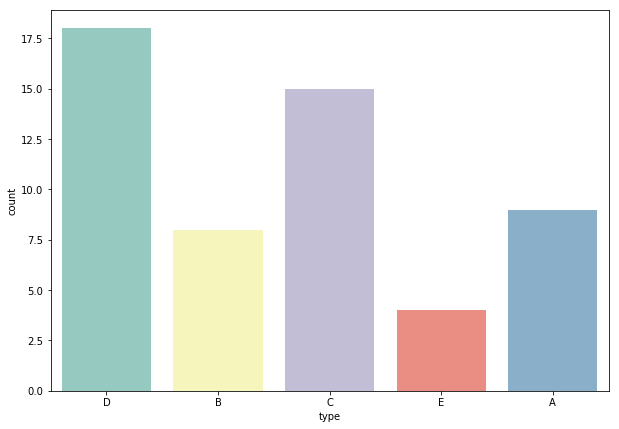

In [12]:
#--- Various types ---
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
ax = sns.countplot(x="type", data=df_stores, palette="Set3")

** Types of stores across cities and states**

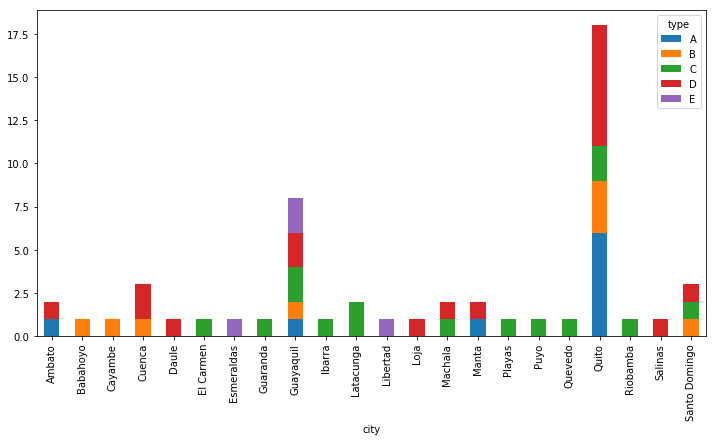

In [20]:
ct = pd.crosstab(df_stores.city, df_stores.type)

ct.plot.bar(figsize = (12, 6), stacked=True)
plt.legend(title='type')

plt.show()

* Type C and A are more widespread across cities.
* Only Guayaquil houses stores of all types!
* City Quito houses a huge number of stores. It is probably a population hub!

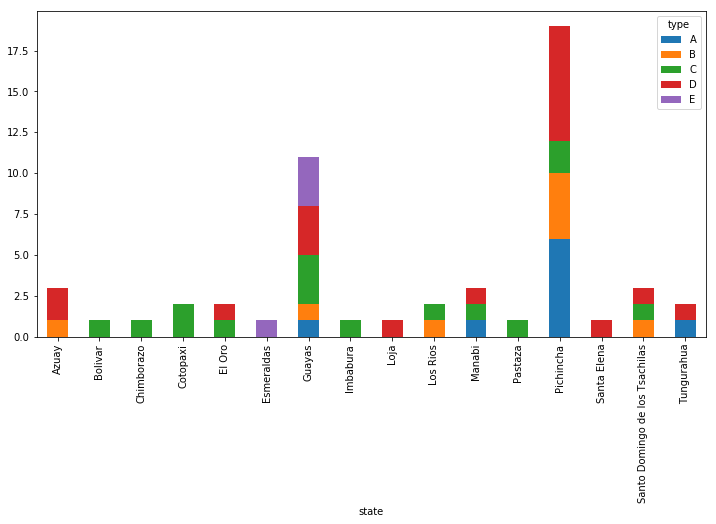

In [21]:
ct = pd.crosstab(df_stores.state, df_stores.type)
ct.plot.bar(figsize = (12, 6), stacked=True)
plt.legend(title='type')
plt.show()

* Type C is more widespread than any other typ.
* State Guayas has all types of stores.
* State Pichincha has a large number of stores

** Clusters**

It is claimed that `cluster` is a grouping of similar stores. So let us find the total number of such grouping.

In [14]:
df_stores.cluster.sum()

458

### Inferences:
* So there are 458 stores spread across these cities. 
* 54 is the number of unique stores.

**Distribution of different clusters**

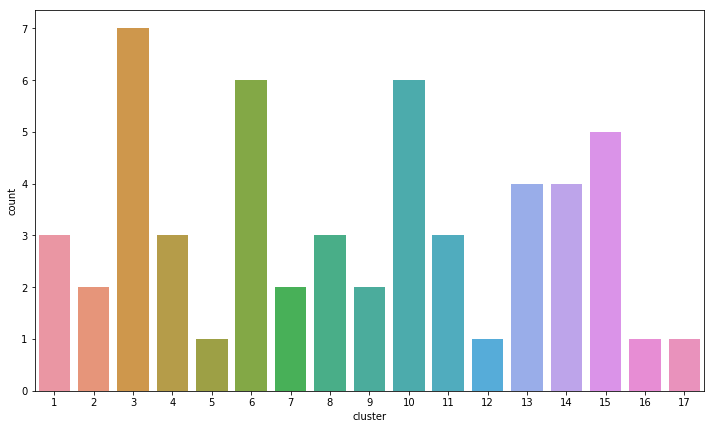

In [61]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 7)
ax = sns.countplot(x="cluster", data=df_stores)

Stores usually prefer clusters of 3, 6, 10 or 15 predominantly.

** Distribution of all stores across cities **

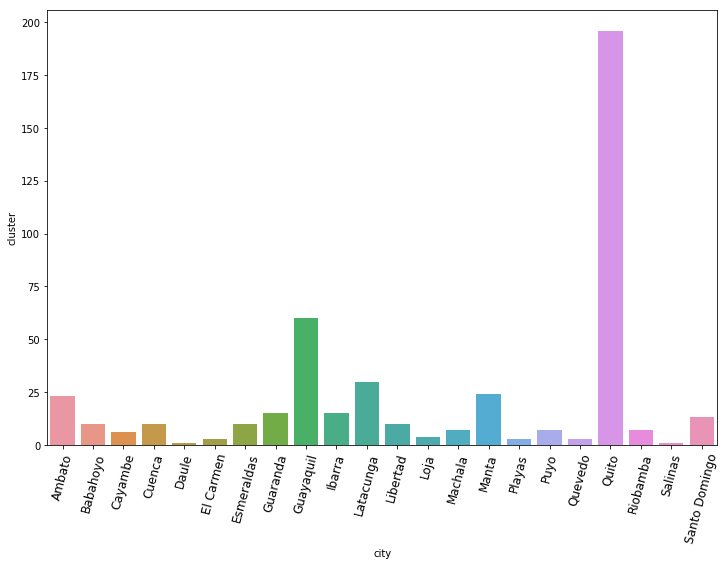

In [15]:
mm = (df_stores.groupby(['city']).sum())

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax = sns.barplot(x = mm.index, y= "cluster", data = mm)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 75, fontsize = 12)

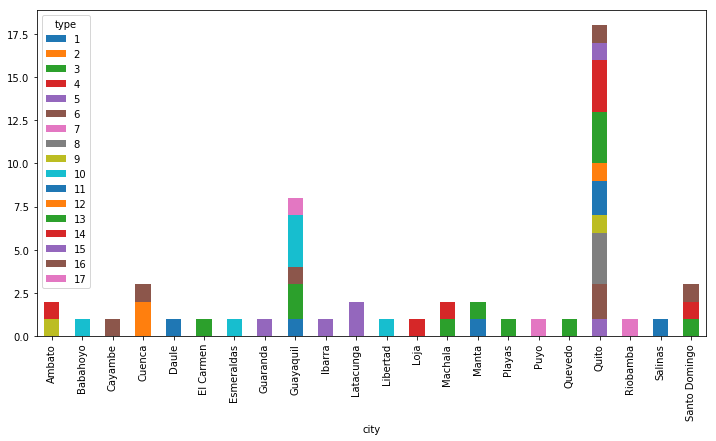

In [57]:
ct = pd.crosstab(df_stores.city, df_stores.cluster)
ct.plot.bar(figsize = (12, 6), stacked=True)
plt.legend(title='cluster')
plt.show()

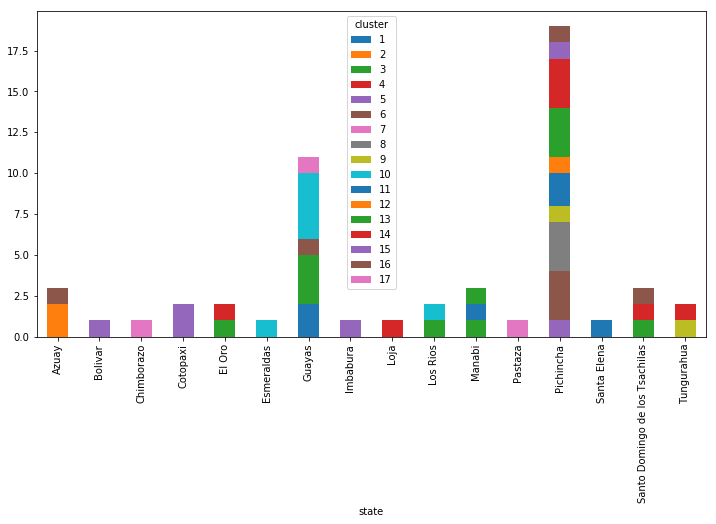

In [58]:
ct = pd.crosstab(df_stores.state, df_stores.cluster)
ct.plot.bar(figsize = (12, 6), stacked=True)
plt.legend(title='cluster')
plt.show()

## One-Hot Encoding

We have three columns of type **object**, which must be converted to a form digestible by ML algorithms.

In [ ]:
obj_cols = list(df_stores.select_dtypes(include=['object']).columns)
for col in obj_cols:
    df_stores[col], _ = pd.factorize(df_stores[col])
    
df_stores.head(10)

## Memory Check

In [ ]:
mem = df_stores.memory_usage(index=True).sum()
print("Memory consumed by stores dataframe initially  :   {} MB" .format(mem/ 1024**2))

change_datatype(df_stores)
change_datatype_float(df_stores)

mem = df_stores.memory_usage(index=True).sum()
print("\n Memory consumed by stores dataframe later  :   {} MB" .format(mem/ 1024**2))

# 2. items.csv

In [22]:
print(df_items.shape)
df_items.head()

(4100, 4)


,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


## Checking Missing Values

In [23]:
df_items.isnull().values.any()

False

## Analyzing Datatypes

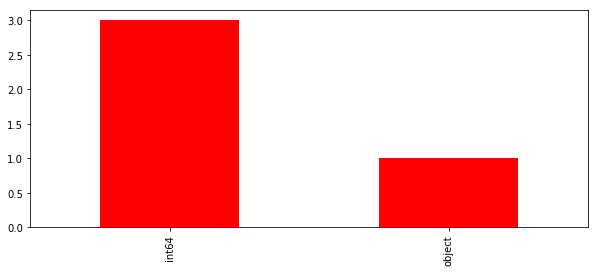

[dtype('int64') dtype('O')]
2


In [51]:
fig = plt.figure(figsize=(10,4))
pp = pd.value_counts(df_items.dtypes)
pp.plot.bar(color='red')
plt.show()

print(df_items.dtypes.unique())
print(df_items.dtypes.nunique())

## Data Exploration & Visualisation

In [25]:
df_items.item_nbr.nunique()

4100

**Distribution of  various families of items**

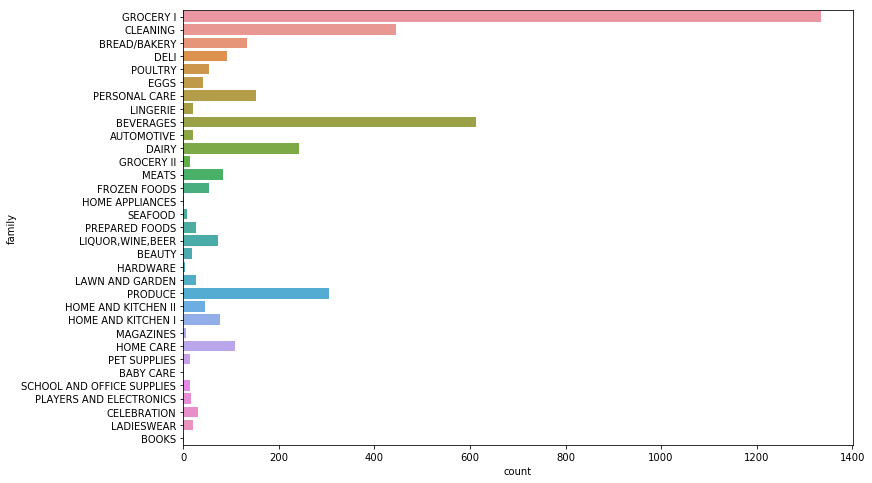

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax = sns.countplot(y = "family", data = df_items)

### Inference:
Most of the unique items belong to categories:
* Grocery I
* Cleaning
* Beverages



**Distribution of perishable goods by family**

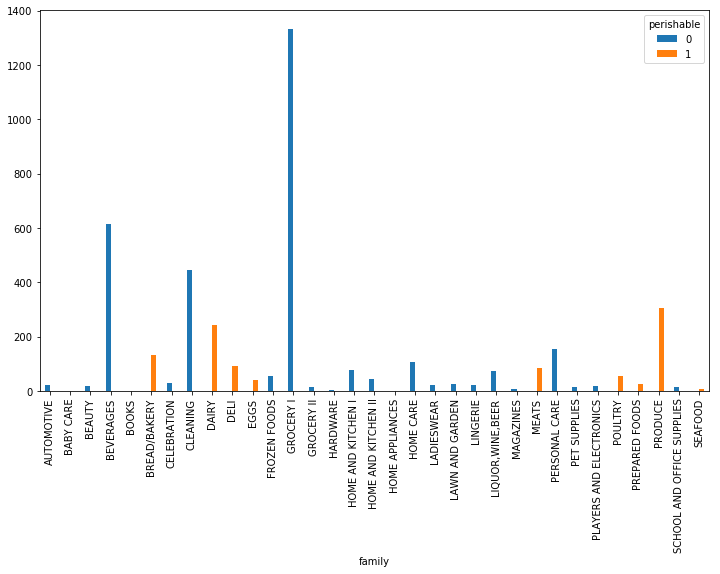

In [63]:
ct = pd.crosstab(df_items.family, df_items.perishable)
ct.plot.bar(figsize = (12, 7), stacked=True)
plt.legend(title='perishable')
plt.show()

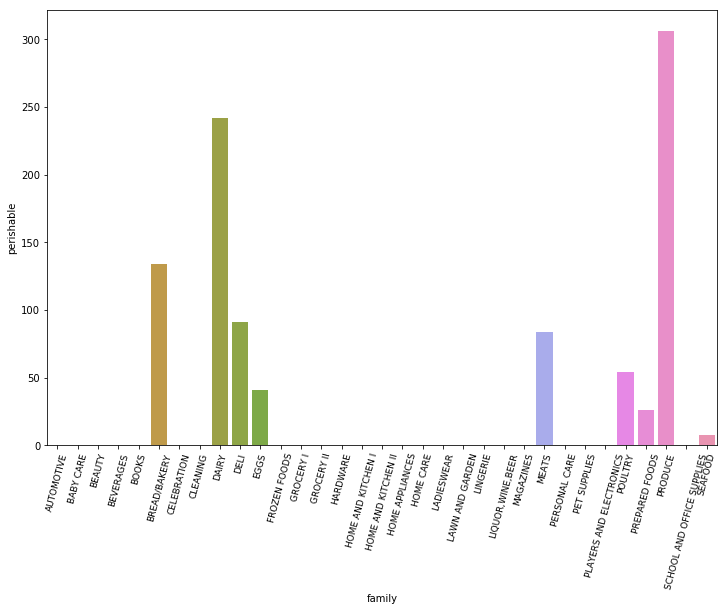

In [27]:
''' 
mc = (df_items.groupby(['family']).sum())
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax = sns.barplot(x = mc.index, y= "perishable", data = mc)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 75, fontsize = 9)
'''

**Distrbution of number of unique classes per family of items.**

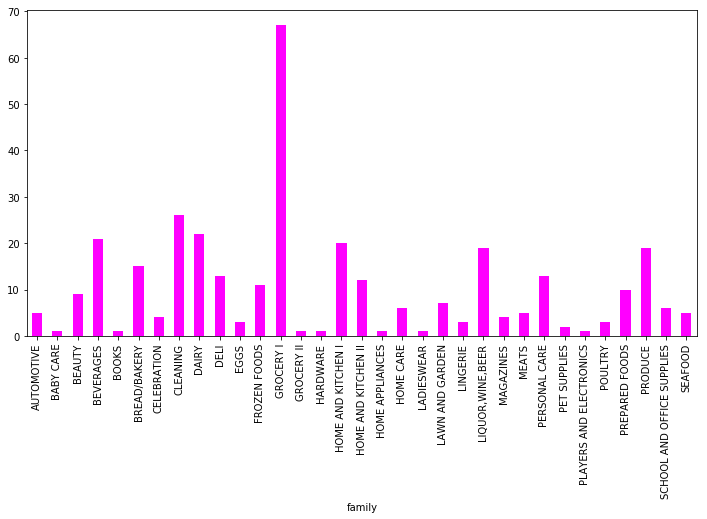

In [65]:
xc = df_items.groupby(['family'])['class'].nunique()
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
xc.plot.bar(color='magenta')
plt.show()

### Inference:
* Grocery I family has the most number of classes of items present.

## One-Hot Encoding

In [ ]:
obj_cols = list(df_items.select_dtypes(include=['object']).columns)
for col in obj_cols:
    df_items[col], _ = pd.factorize(df_items[col])
    
df_items.head(10)

## Memory Check

In [ ]:
mem = df_items.memory_usage(index=True).sum()
print("Memory consumed by items dataframe initially  :   {} MB" .format(mem/ 1024**2))

change_datatype(df_items)
change_datatype_float(df_items)

mem = df_items.memory_usage(index=True).sum()
print("\n Memory consumed by items dataframe later  :   {} MB" .format(mem/ 1024**2))

# 3. transactions.csv

In [29]:
print(df_transactions.shape)
df_transactions.head()

(83488, 3)


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


## Checking Missing Values

In [52]:
df_transactions.isnull().values.any()

False


## Analyzing Datatypes

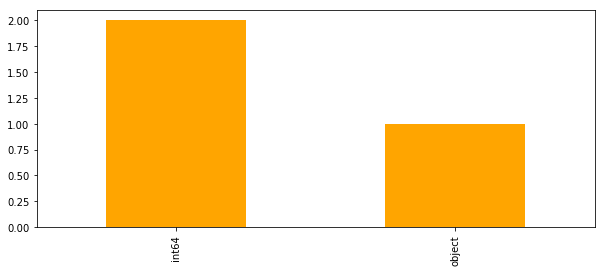

[dtype('O') dtype('int64')]
2


In [53]:
fig = plt.figure(figsize=(10,4))
pp = pd.value_counts(df_transactions.dtypes)
pp.plot.bar(color='orange')
plt.show()

print(df_transactions.dtypes.unique())
print(df_transactions.dtypes.nunique())

**Distribution of toal number of transactions made per individual store**

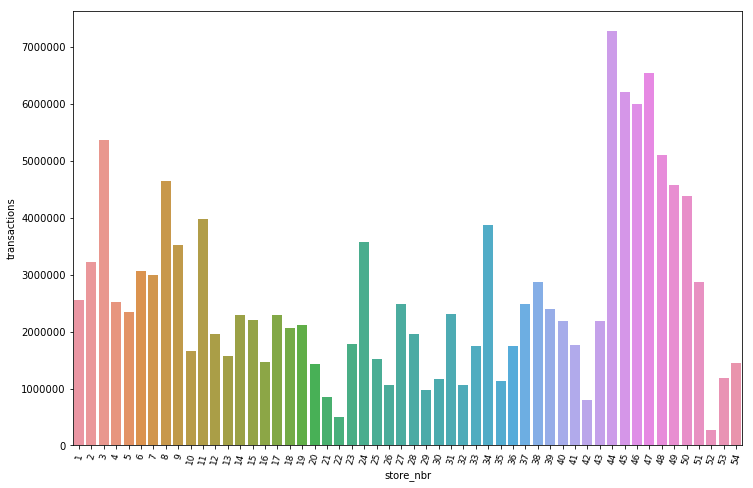

In [68]:
pc = (df_transactions.groupby(['store_nbr']).sum())
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax = sns.barplot(x = pc.index, y= "transactions", data = pc)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 75, fontsize = 9)

### Inference:
* Only 4 stores have crossed the 6M transcation mark.
* Few stores have transactions of less than a million.

Below is another form of representing the above graph:

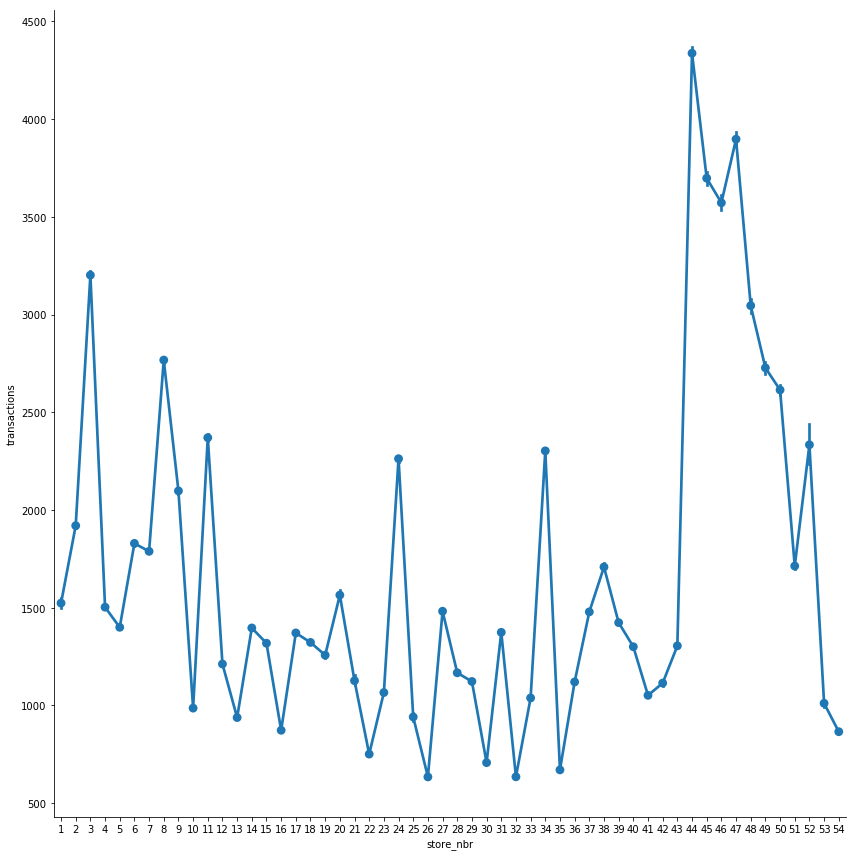

In [67]:
g = sns.factorplot(x="store_nbr", y="transactions", size = 12, data=df_transactions)


**Converting date column from type *object* to type *datetime* **

In [ ]:
df_transactions.date = pd.to_datetime(df_transactions.date)
df_transactions.date.dtype

Store numbers with **max** and **min** transcations over time

In [30]:
max_transaction = df_transactions['transactions'].max()
min_transaction = df_transactions['transactions'].min()

print(df_transactions.store_nbr[df_transactions['transactions'] == max_transaction])
print(df_transactions.store_nbr[df_transactions['transactions'] == min_transaction])

52011    44
Name: store_nbr, dtype: int64
65479    43
Name: store_nbr, dtype: int64


** List of stores having the top 100 transactions **

In [31]:
top_trans = df_transactions.nlargest(100, 'transactions')
print(top_trans.store_nbr.unique())

[44 46 47 45 48 49  3]


** List of stores having the top 500 transactions **

In [32]:
top_trans = df_transactions.nlargest(500, 'transactions')
print(top_trans.store_nbr.unique())

[44 46 47 45 48 49  3 50  8]


** List of stores having the top 1000 transactions **

In [33]:
top_trans = df_transactions.nlargest(1000, 'transactions')
print(top_trans.store_nbr.unique())

[44 46 47 45 48 49  3 50  8 11]


## Memory Reduction

In [ ]:
mem = df_transactions.memory_usage(index=True).sum()
print("Memory consumed by transactions dataframe initially  :   {} MB" .format(mem/ 1024**2))

change_datatype(df_transactions)
change_datatype_float(df_transactions)

mem = df_transactions.memory_usage(index=True).sum()
print("\nMemory consumed by transactions dataframe later  :   {} MB" .format(mem/ 1024**2))

# 4. holidays_events.csv

In [54]:
print(df_holidays_events.shape)
df_holidays_events.head()

(350, 6)


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


## Checking Missing Values

In [55]:
df_holidays_events.isnull().values.any()

False

## Analyzing Datatypes

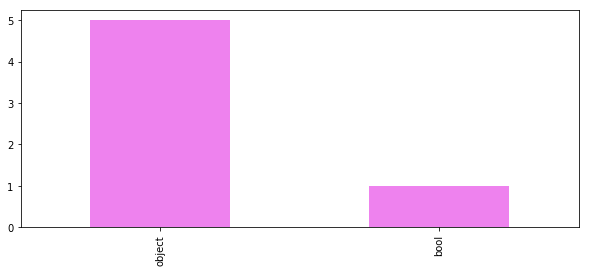

[dtype('O') dtype('bool')]
2


In [56]:
fig = plt.figure(figsize=(10,4))
pp = pd.value_counts(df_holidays_events.dtypes)
pp.plot.bar(color='violet')
plt.show()

print(df_holidays_events.dtypes.unique())
print(df_holidays_events.dtypes.nunique())

** Various types of holidays present **

In [69]:
print(df_holidays_events.type.unique())
df_holidays_events.type.value_counts()

['Holiday' 'Transfer' 'Additional' 'Bridge' 'Work Day' 'Event']


Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: type, dtype: int64

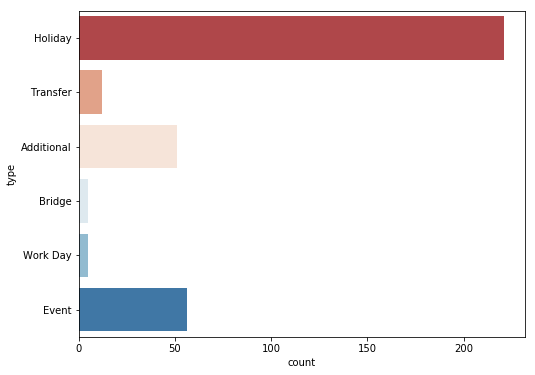

In [70]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax = sns.countplot( y="type", data=df_holidays_events, palette="RdBu")

**Distribution of different locales of holidays**

In [71]:
print(df_holidays_events.locale.unique())
df_holidays_events.locale.value_counts()

['Local' 'Regional' 'National']


National    174
Local       152
Regional     24
Name: locale, dtype: int64

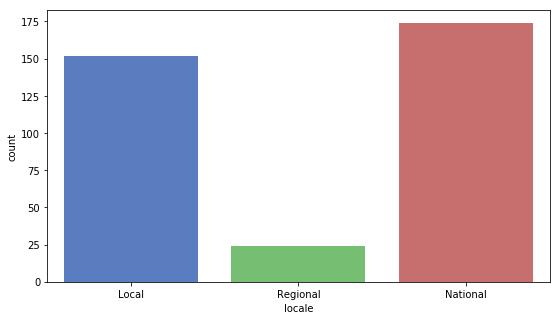

In [75]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 5)
ax = sns.countplot( x="locale", data=df_holidays_events, palette="muted")

**Distribtuion of types of holidays with respect to various locales**

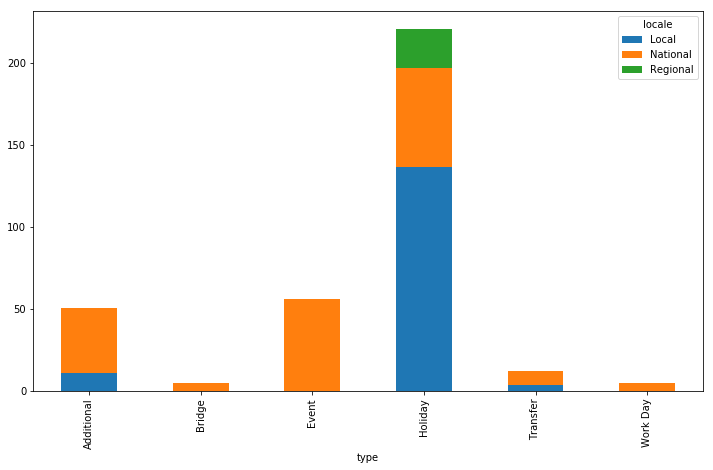

'\nfig, ax = plt.subplots()\nfig.set_size_inches(12, 8)\nsns.countplot( x="type", hue="locale", data=df_holidays_events, palette="muted")\n'

In [79]:
ct = pd.crosstab(df_holidays_events.type, df_holidays_events.locale)
ct.plot.bar(figsize = (12, 7), stacked=True)
plt.legend(title='locale')
plt.show()
'''
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.countplot( x="type", hue="locale", data=df_holidays_events, palette="muted")
'''

**Distribution of holidays transferred vs non-transferred**

In [80]:
df_holidays_events.transferred.value_counts()

False    338
True      12
Name: transferred, dtype: int64

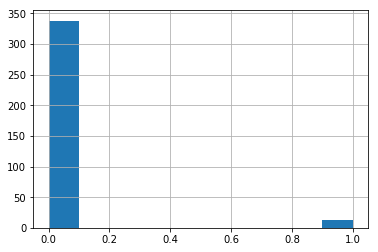

In [81]:
df_holidays_events.transferred.hist()

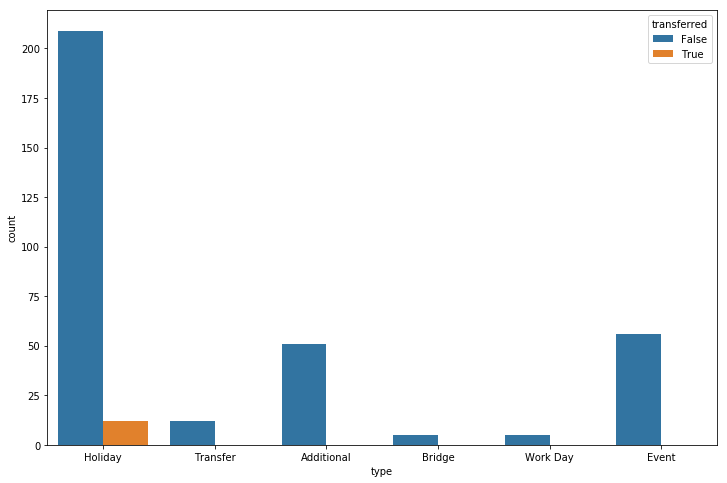

In [83]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.countplot( x="type", hue="transferred", data=df_holidays_events)

In [ ]:
g = sns.factorplot(x="who", y="survived", col="class",
                    data=df_holidays_events, saturation=.5,
                    kind="bar", ci=None, aspect=.6)


### Inferences:
* Holidays of type *holiday* alone were transferred.
* Only 12 holidays were transferred throughout the occurrence.
* *Regional* locales were of type *holiday* only.
* Apart from these the above graphs are self-explanatory!

## One-Hot Encoding

In [ ]:
obj_cols = list(df_holidays_events.select_dtypes(include=['object']).columns)
for col in obj_cols:
    df_holidays_events[col], _ = pd.factorize(df_holidays_events[col])
    
df_holidays_events.head(10)

## Memory Reduction

In [ ]:
mem = df_holidays_events.memory_usage(index=True).sum()
print("Memory consumed by transactions dataframe initially  :   {} MB" .format(mem/ 1024**2))

change_datatype(df_holidays_events)
change_datatype_float(df_holidays_events)

mem = df_holidays_events.memory_usage(index=True).sum()
print("\nMemory consumed by transactions dataframe later  :   {} MB" .format(mem/ 1024**2))

# 5. oil.csv

In [34]:
print(df_oil.shape)
df_oil.head()

(1218, 2)


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


## Checking Missing Values

In [35]:
df_oil.isnull().values.any()

True

## Analyzing Datatypes

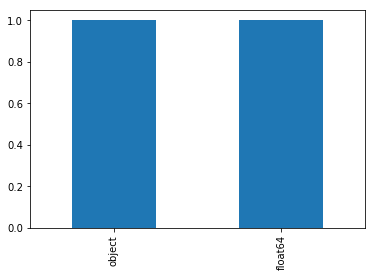

[dtype('O') dtype('float64')]
2


In [36]:
pp = pd.value_counts(df_oil.dtypes)
pp.plot.bar()
plt.show()

print(df_oil.dtypes.unique())
print(df_oil.dtypes.nunique())

**Converting date column from type object to type datetime**

In [39]:
df_oil.date = pd.to_datetime(df_oil.date)
df_oil.date.dtype

dtype('<M8[ns]')

**Dates having highest and lowest oil prices**

In [44]:
max_transaction = df_transactions['transactions'].max()
min_transaction = df_transactions['transactions'].min()

print('Maximum price date : ', df_oil.date[df_oil['dcoilwtico'] == df_oil['dcoilwtico'].max()])
print('Minimum price date : ', df_oil.date[df_oil['dcoilwtico'] == df_oil['dcoilwtico'].min()])

Maximum price date :  178   2013-09-06
Name: date, dtype: datetime64[ns]
Minimum price date :  812   2016-02-11
Name: date, dtype: datetime64[ns]


/opt/conda/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


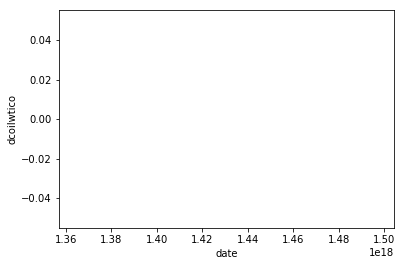

In [40]:
ax = sns.tsplot(time="date", value = "dcoilwtico", data = df_oil)

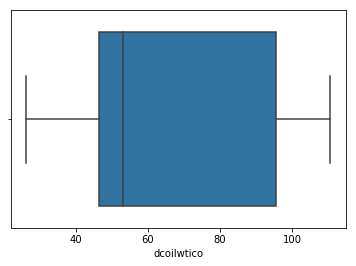

In [43]:
ax = sns.boxplot(x=df_oil["dcoilwtico"])

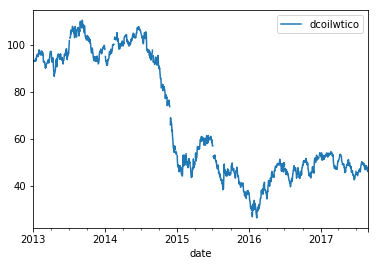

In [46]:
plt.figure(figsize=(12, 6))
df_oil.set_index('date').plot()

#plt.show()

# 6. train.csv

In [ ]:
print(df_train.shape)
df_train.head()

In [ ]:
mem = df_train.memory_usage(index=True).sum()
print("Memory consumed by train dataframe initially  :   {} MB" .format(mem/ 1024**2))

**The size is Huge! Initiating memory reduction straight away!**

In [ ]:
change_datatype(df_train)
change_datatype_float(df_train)

## Checking Missing Values

In [ ]:
df_train.isnull().values.any()

In [ ]:
df_train.columns[df_train.isnull().any()].tolist()

Imputing missing values with -1

In [ ]:
df_train[[ 'onpromotion']] = df_train[['onpromotion']].fillna(np.int(-1))

Missing values are only found in column **onpromotion**.

## Analyzing Datatypes

In [ ]:
pp = pd.value_counts(df_train.dtypes)
pp.plot.bar()
plt.show()

print(df_train.dtypes.unique())
print(df_train.dtypes.nunique())

## Analysis of target variable *unitsales*

In [ ]:
stores_unitsales = (df_train.groupby(['store_nbr']).sum())
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax = sns.barplot(x = stores_unitsales.index, y= "unit_sales", data = stores_unitsales)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 75, fontsize = 12)


In [ ]:
''' 
items_unitsales = (df_train.groupby(['item_nbr']).sum())
 
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax = sns.barplot(x = items_unitsales.index, y= "unit_sales", data = items_unitsales)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 75, fontsize = 12)
''' 

## Analysis of target variable *onpromotion*

In [ ]:
print(df_train.onpromotion.nunique())
print(df_train.onpromotion.unique())

In [ ]:
#--- non Nan rows ---
df_train.onpromotion.count()

## *TO BE CONTINUED......*

# What is to be done?

* **Merging all csv files EXCEPT train csv file.**
* **Analysis of train dataset** (unfortunately cannot be done due to kernel timeout :( )
* **Merge the above dataframes with train dataset and perform further analysis**
* **Release a baseline model**


# STAY TUNED !!!